In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

# Домашняя работа: деревья решений

В этой домашней работе вам предстоит научиться предсказывать цены товаров из маркетплейса Azamon.

Требования к домашней работе:
- Во всех графиках должны быть подписи через title, legend, etc.
- Во время обучения моделей проверяйте, что у вас не текут данные. Обычно это позитивно влияет на качество модели на тесте, но негативно влияет на оценку 🌚
- Если вы сдаете работу в Google Colaboratory, убедитесь, что ваша тетрадка доступна по ссылке.
- Использование мемов допускается, но необходимо соблюдать меру. Несодержательная работа, состоящая только из мемов, получает 0 баллов.

# Загрузка и подготовка данных

In [44]:
df = pd.read_csv('amazon_co-ecommerce_sample.csv').drop(columns=[
    'product_name',
    'index',
    'uniq_id',
    'customers_who_bought_this_item_also_bought',
    'items_customers_buy_after_viewing_this_item',
    'sellers',
    'description', # text
    'product_information', # text
    'product_description', # text
    'customer_questions_and_answers', # text
    'customer_reviews', # text
])

In [45]:
df.dtypes

manufacturer                         object
price                                object
number_available_in_stock            object
number_of_reviews                    object
number_of_answered_questions        float64
average_review_rating                object
amazon_category_and_sub_category     object
dtype: object

- manufacturer - Производитель
- price - Цена
- number_available_in_stock - Количество товара в наличии на складе
- number_of_reviews - Количество отзывов
- number_of_answered_questions - Количество ответов на вопросы
- average_review_rating - Средний рейтинг отзывов
- amazon_category_and_sub_category - категория и подкатегория амазон

## Очистка данных (1 балл)

Посмотрите на признаки. Есть ли в них пропуски? Какое соотношение между NaN'ами и общим количеством данных? 
 - **Есть ли смысл выкидывать какие-либо данные из этого датасета?**
 
    Можно выкинуть строки, где не указана цена

In [46]:
df.head()

,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category
0,Hornby,£3.42,5 new,15,1.0,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
1,FunkyBuys,£16.99,NaN,2,1.0,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
2,ccf,£9.99,2 new,17,2.0,3.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
3,Hornby,£39.99,NaN,1,2.0,5.0 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
4,Hornby,£32.19,NaN,3,2.0,4.7 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...


In [47]:
df.shape

(10000, 7)

In [48]:
df.isnull().sum()/df.shape[0]

manufacturer                        0.0007
price                               0.1435
number_available_in_stock           0.2500
number_of_reviews                   0.0018
number_of_answered_questions        0.0765
average_review_rating               0.0018
amazon_category_and_sub_category    0.0690
dtype: float64

In [49]:
df = df[df["price"].notnull()]
df.isnull().sum()/df.shape[0]

manufacturer                        0.000584
price                               0.000000
number_available_in_stock           0.260245
number_of_reviews                   0.001751
number_of_answered_questions        0.078692
average_review_rating               0.001751
amazon_category_and_sub_category    0.064448
dtype: float64

## Подготовка данных (3 балла)

Обработайте признаки. Выполните кодирование категориальных признаков, заполните пропуски в числовых признаках. Обратите внимание, что в датасете есть признак, который разбивается на несколько подпризнаков. 
**Что это за признак? Закодируйте и его.**
amazon_category_and_sub_category и number_available_in_stock

Дополнительные вопросы (+ 1 балл):
- **Какие из признаков в этом датасете лучше кодировать через ordinal encoding?**
    Никакие.
- **Какие из признаков допустимо кодировать через one-hot?**
    amazon_category_and_sub_category, status(чуть ниже мы его добавим), manufacturer (но не все)

Прим.: суммарно за эту секцию можно получить до 4 баллов.

In [50]:
values = {"number_available_in_stock": "0\xa0other_status", 
          "number_of_reviews": 0, 
          "number_of_answered_questions": 0, 
          "average_review_rating": 0,
          "manufacturer": "Unknown",
          "amazon_category_and_sub_category": "other_category"}
df.fillna(value=values, inplace=True)

df["price"] = df["price"].apply(lambda w: str(w).replace(",",""))
df["price"] = df["price"].apply(lambda w: str(w).replace("£",""))
df["price"] = df["price"].apply(lambda w: (float(w[w.find('-')+1:])+float(w[:w.find('-')]))/2 if w.find('-')!=-1 else w)

df["number_of_reviews"] = df["number_of_reviews"].apply(lambda w: str(w).replace(",",""))

df["average_review_rating"] = df["average_review_rating"].apply(lambda w: str(w).replace("out of 5 stars",""))

df[['number_available_in_stock', 'status']] = df["number_available_in_stock"].str.split('\xa0', expand = True)

In [51]:
df.isnull().sum()

manufacturer                        0
price                               0
number_available_in_stock           0
number_of_reviews                   0
number_of_answered_questions        0
average_review_rating               0
amazon_category_and_sub_category    0
status                              0
dtype: int64

Приведём типы

In [52]:
columns = {"average_review_rating":"float64", 
           "price":"float64",
          }
df = df.astype(columns)
df["number_available_in_stock"] = df["number_available_in_stock"].apply(lambda w: int(w))
df["number_of_reviews"] = df["number_of_reviews"].apply(lambda w: int(w))
df["number_of_answered_questions"] = df["number_of_answered_questions"].apply(lambda w: int(w))

df.dtypes

manufacturer                         object
price                               float64
number_available_in_stock             int64
number_of_reviews                     int64
number_of_answered_questions          int64
average_review_rating               float64
amazon_category_and_sub_category     object
status                               object
dtype: object

Разобьем amazon_category_and_sub_category на несколько подпризнаков

In [53]:
df[['catalog', 'category', 'subcategory', 'items', 'main_item']] = df["amazon_category_and_sub_category"].str.split('>', expand = True)

In [54]:
df.drop(columns="amazon_category_and_sub_category", inplace = True)
df.dtypes

manufacturer                     object
price                           float64
number_available_in_stock         int64
number_of_reviews                 int64
number_of_answered_questions      int64
average_review_rating           float64
status                           object
catalog                          object
category                         object
subcategory                      object
items                            object
main_item                        object
dtype: object

Очень много различных производителей, оставим в df только тех производителей, у которых больше 30 товаров.

In [55]:
manufactur = df["manufacturer"].value_counts()[df["manufacturer"].value_counts() > 25].index
df["manufacturer"] = df["manufacturer"].apply(lambda w: w if w in manufactur else 'Unknown')

One hot encoding

In [56]:
category = ["manufacturer","status", "catalog", "category", "subcategory" ,"items", "main_item"]

dummy = pd.get_dummies(df[category])
df = df.drop(columns=category, axis = 1)
df = df.join(dummy)

In [57]:
df.shape

(8565, 405)

In [58]:
per3 = np.percentile(df["price"], 3)
per97 = np.percentile(df["price"], 97)

df = df[(df["price"] > per3)&(df["price"] < per97)]

In [59]:
from sklearn.model_selection import train_test_split

y = df["price"]
X = df.drop(columns=["price"])#, "manufacturer"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучение модели (3 балла)

## Бейзлайн

Обучите базовую модель. Для этого используйте `sklearn.dummy.DummyRegressor`. Какое качество она показывает на тесте? Посчитайте MSE, RMSE.

In [61]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, r2_score

model_DR = DummyRegressor()

model_DR.fit(X_train, y_train)

y_pred = model_DR.predict(X_train)
y_test_pred = model_DR.predict(X_test)

print("Train MSE: ",mean_squared_error(y_train, y_pred, squared=True))
print("Test MSE: ",mean_squared_error(y_test, y_test_pred, squared=True))

print("\nTrain RMSE: ",mean_squared_error(y_train, y_pred, squared=False))
print("Test RMSE: ",mean_squared_error(y_test, y_test_pred, squared=False))

'''Train MSE:  229.03894212951343
Test MSE:  228.9955203878489

Train RMSE:  15.134032579901282
Test RMSE:  15.132597939146104'''

Train MSE:  229.03894212951343
Test MSE:  228.9955203878489

Train RMSE:  15.134032579901282
Test RMSE:  15.132597939146104


'Train MSE:  229.03894212951343\nTest MSE:  228.9955203878489\n\nTrain RMSE:  15.134032579901282\nTest RMSE:  15.132597939146104'

## Дерево решений

Обучите регрессионное дерево решений, проверьте качество этой модели на тестовой выборке. Улучшилось ли качество по сравнению с базовой моделью? Оцените r2_score обученной модели.

In [62]:
from sklearn.tree import DecisionTreeRegressor

model_decision_tree = DecisionTreeRegressor()

model_decision_tree.fit(X_train, y_train)

y_pred = model_decision_tree.predict(X_train)
y_test_pred = model_decision_tree.predict(X_test)
print("Train r2_score: ", r2_score(y_train, y_pred))
print("Test r2_score: ", r2_score(y_test, y_test_pred))

print("\nTrain MSE: ",mean_squared_error(y_train, y_pred, squared=True))
print("Test MSE: ",mean_squared_error(y_test, y_test_pred, squared=True))

print("\nTrain RMSE: ",mean_squared_error(y_train, y_pred, squared=False))
print("Test RMSE: ",mean_squared_error(y_test, y_test_pred, squared=False))

Train r2_score:  0.8613517332700001
Test r2_score:  -0.3874890327734115

Train MSE:  31.755852339929785
Test MSE:  317.7065119130834

Train RMSE:  5.635233122057133
Test RMSE:  17.82432360324182


## Линейная регрессия

Попробуйте обучить линейную регрессию с параметрами по умолчанию. Оцените r2_score на тестовой выборке. Сравните качество с деревом решений. 

In [63]:
from sklearn.linear_model import LinearRegression

model_linear = LinearRegression()

model_linear.fit(X_train, y_train)

y_pred = model_linear.predict(X_train)
y_test_pred = model_linear.predict(X_test)
print("Train r2_score: ", r2_score(y_train, y_pred))
print("Test r2_score: ", r2_score(y_test, y_test_pred))

print("\nTrain MSE: ",mean_squared_error(y_train, y_pred, squared=True))
print("Test MSE: ",mean_squared_error(y_test, y_test_pred, squared=True))

print("\nTrain RMSE: ",mean_squared_error(y_train, y_pred, squared=False))
print("Test RMSE: ",mean_squared_error(y_test, y_test_pred, squared=False))

Train r2_score:  0.2727324802599578
Test r2_score:  -1.7959674709182532e+16

Train MSE:  166.57258336641428
Test MSE:  4.1123969070534804e+18

Train RMSE:  12.906300142427119
Test RMSE:  2027904560.6372802


Чем ближе r2_score к 1 тем модель лучше, как мы видим, обученная линейная регрессия показывает очень плохие результаты

# Гиперпараметры (2 балла)

Переберите несколько гиперпараметров (не более двух-трёх). Обратите внимание, как эти параметры влияют на ошибку модели на тестовой выборке. Постройте для глубины дерева график переобучения (fitting curve) аналогичный тому, что мы строили на занятии. Найдите глубину дерева, начиная с которой модель начинает переобучаться.

In [64]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

scoring = make_scorer(r2_score)
g_cv = GridSearchCV(DecisionTreeRegressor(random_state=42),
              param_grid={"min_samples_split": [5 ,10, 20, 40],
                          "max_depth": [2, 6, 8, 10, 20, 50, 100],
                          "min_samples_leaf": [20, 40, 100],
                          "max_leaf_nodes": [5, 20, 100]},
              scoring=scoring, cv=5, refit=True)

g_cv.fit(X_train, y_train)

result = g_cv.cv_results_

In [65]:
print("MSE:", mean_squared_error(y_test, g_cv.best_estimator_.predict(X_test), squared=True))
print("RMSE:", mean_squared_error(y_test, g_cv.best_estimator_.predict(X_test), squared=False))
print("r2_score: ", r2_score(y_test, g_cv.best_estimator_.predict(X_test)))
print("\nBest Hyperparameters::\n{}".format(g_cv.best_params_))

MSE: 194.23168628473658
RMSE: 13.936702848404876
r2_score:  0.1517506741854734

Best Hyperparameters::
{'max_depth': 20, 'max_leaf_nodes': 20, 'min_samples_leaf': 20, 'min_samples_split': 5}


In [66]:
df = pd.DataFrame(data=result)
df.dtypes

mean_fit_time              float64
std_fit_time               float64
mean_score_time            float64
std_score_time             float64
param_max_depth             object
param_max_leaf_nodes        object
param_min_samples_leaf      object
param_min_samples_split     object
params                      object
split0_test_score          float64
split1_test_score          float64
split2_test_score          float64
split3_test_score          float64
split4_test_score          float64
mean_test_score            float64
std_test_score             float64
rank_test_score              int32
dtype: object

Text(0.5, 1.0, 'Влияние глубины и листьев на производительность модели')

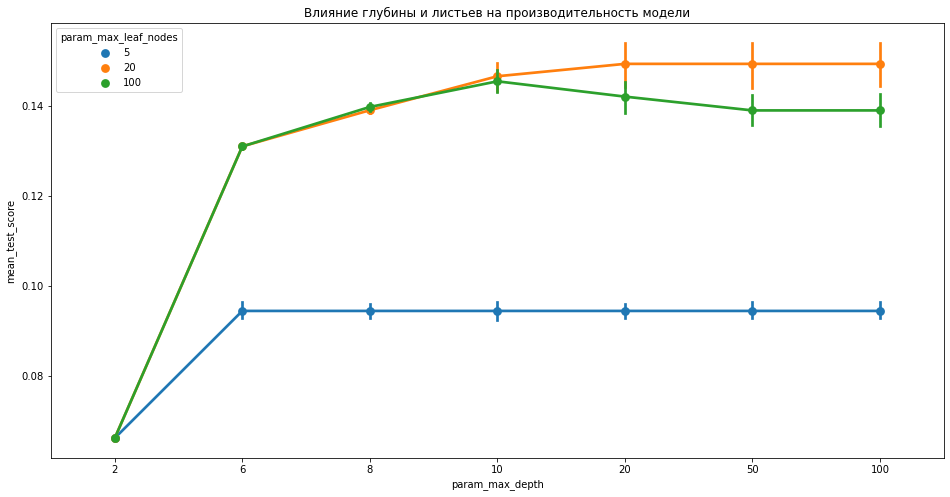

In [67]:
plt.figure(figsize=(16,8))
seaborn.pointplot(data=df[['mean_test_score',
                       'param_max_leaf_nodes',
                       'param_max_depth']],
             y='mean_test_score',x='param_max_depth',
            hue='param_max_leaf_nodes')
plt.title("Влияние глубины и листьев на производительность модели")

In [68]:
import seaborn as sns

def plot_fitting_curve(parameter: str, values: list, score, X_train, X_test, y_train, y_test):
    train_curve = []
    test_curve = []
    for value in values:
        # инициализация объекта из словаря
        # распаковка словаря через ** эквивалентна перечислению аргументов
        model = DecisionTreeRegressor(**{parameter: value})
        model.fit(X_train, y_train)
        y_pred_train, y_pred_test = model.predict(X_train), model.predict(X_test)
        train_curve.append(score(y_train, y_pred_train))#, average='macro'))
        test_curve.append(score(y_test, y_pred_test))#, average='macro'))
    sns.lineplot(x=values, y=train_curve)
    sns.lineplot(x=values, y=test_curve)

Text(0, 0.5, 'r2_score')

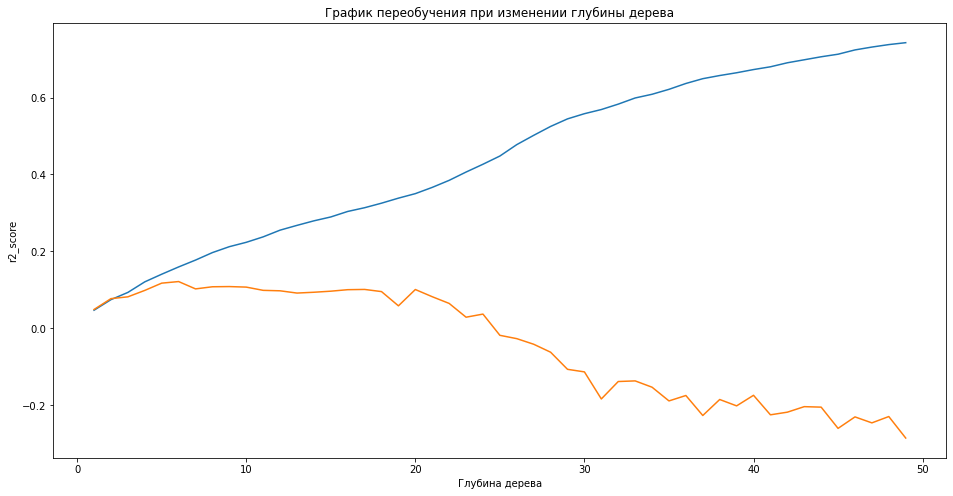

In [69]:
plt.figure(figsize=(16,8))
plot_fitting_curve('max_depth', np.arange(1, 50), r2_score, X_train, X_test, y_train, y_test)

plt.title("График переобучения при изменении глубины дерева")
plt.xlabel("Глубина дерева")
plt.ylabel("r2_score")

Если мы возьмем глубину дерева >6, то уже наше дерево переобучиться

# Простое ансамблирование (1 балл)

В этой секции мы реализуем простой ансамбль деревьев.

In [70]:
class EnsembleTreeRegressor:
    def __init__(self, num_trees=5, samples_frac=0.8, **model_kwargs):
        self.num_trees= num_trees
        self._samples_frac = 0.8
        self._trees = [DecisionTreeRegressor(**model_kwargs) for _ in range(num_trees)]
    def fit(self, x, y: pd.Series):
        x = pd.DataFrame(x)
        y = y.reset_index(drop=True)
        x = x.reset_index(drop=True)
        for tree in self._trees:
            tree_x = x.sample(frac=self._samples_frac, random_state=42)
            tree_y = y[tree_x.index]
            tree.fit(tree_x, tree_y)
        return self
    def predict(self, x: pd.DataFrame):
        x = pd.DataFrame(x)
        res = []
        for i in range(self.num_trees):
            res.append(self._trees[i].predict(x))
        return sum(res) / len(res)

Проверьте, работает ли этот ансамбль лучше обычного дерева с параметрами по умолчанию?

Дополнительно переберите максимальную глубину дерева. Проверьте, насколько отличается момент начала переобучения у одиночного дерева и у ансамбля. Зависит ли этот момент от числа деревьев (`num_trees`)? От числа примеров для каждого дерева (`samples_frac`)? Постройте график fitting curve.

In [79]:
#{'max_depth': 20, 'max_leaf_nodes': 20, 'min_samples_leaf': 20, 'min_samples_split': 5}

model_ensemble_tree = EnsembleTreeRegressor(max_depth=20, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split = 5, num_trees = 15)

model_ensemble_tree.fit(X_train, y_train)

y_pred = model_ensemble_tree.predict(X_train)
y_test_pred = model_ensemble_tree.predict(X_test)

print("Train r2_score: ", r2_score(y_train, y_pred))
print("Test r2_score: ", r2_score(y_test, y_test_pred))

print("\nTrain MSE: ",mean_squared_error(y_train, y_pred, squared=True))
print("Test MSE: ",mean_squared_error(y_test, y_test_pred, squared=True))

print("\nTrain RMSE: ",mean_squared_error(y_train, y_pred, squared=False))
print("Test RMSE: ",mean_squared_error(y_test, y_test_pred, squared=False))

Train r2_score:  0.1933105843240609
Test r2_score:  0.1571454139462669

Train MSE:  184.7632903934924
Test MSE:  192.99640160024825

Train RMSE:  13.592766105303674
Test RMSE:  13.892314479605199


Да, этот ансамбль работает чуть лучше на тестовой выборке обычного дерева с параметрами по умолчанию.


In [74]:
def plot_fitting_curve(parameter: str, values: list, score, X_train, X_test, y_train, y_test):
    train_curve = []
    test_curve = []
    for value in values:
        # инициализация объекта из словаря
        # распаковка словаря через ** эквивалентна перечислению аргументов
        model = EnsembleTreeRegressor(**{parameter: value})
        model.fit(X_train, y_train)
        y_pred_train, y_pred_test = model.predict(X_train), model.predict(X_test)
        train_curve.append(score(y_train, y_pred_train))#, average='macro'))
        test_curve.append(score(y_test, y_pred_test))#, average='macro'))
    sns.lineplot(x=values, y=train_curve)
    sns.lineplot(x=values, y=test_curve)

Text(0, 0.5, 'r2_score')

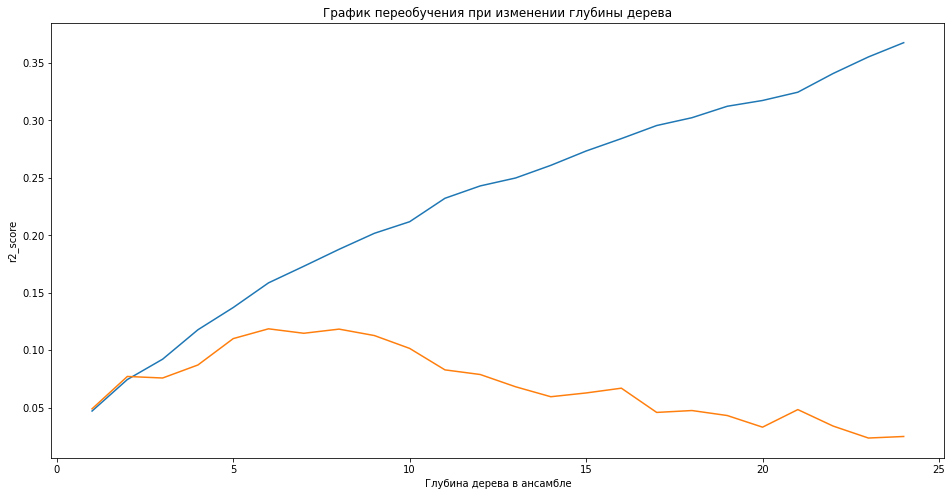

In [75]:
plt.figure(figsize=(16,8))
plot_fitting_curve('max_depth', np.arange(1, 25), r2_score, X_train, X_test, y_train, y_test)

plt.title("График переобучения при изменении глубины дерева")
plt.xlabel("Глубина дерева в ансамбле")
plt.ylabel("r2_score")

Text(0, 0.5, 'r2_score')

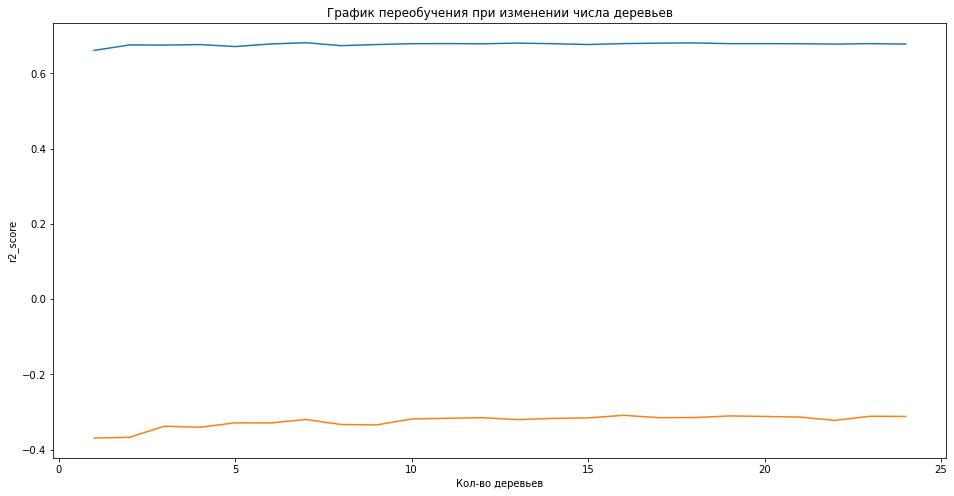

In [77]:
plt.figure(figsize=(16,8))
plot_fitting_curve('num_trees', np.arange(1, 25), r2_score, X_train, X_test, y_train, y_test)

plt.title("График переобучения при изменении числа деревьев")
plt.xlabel("Кол-во деревьев")
plt.ylabel("r2_score")

Text(0, 0.5, 'r2_score')

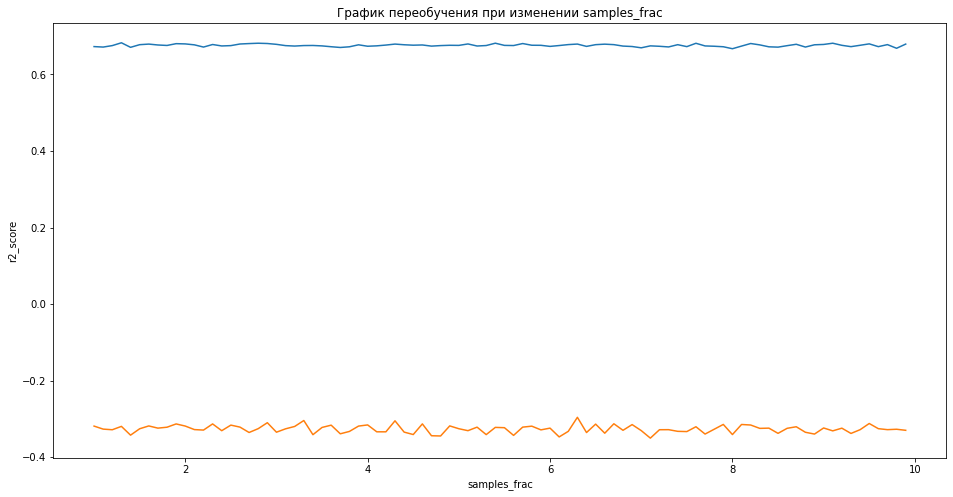

In [78]:
plt.figure(figsize=(16,8))
plot_fitting_curve('samples_frac', np.arange(1, 10, 0.1), r2_score, X_train, X_test, y_train, y_test)

plt.title("График переобучения при изменении samples_frac")
plt.xlabel("samples_frac")
plt.ylabel("r2_score")

In [85]:
from catboost import CatBoostRegressor

catboosting = CatBoostRegressor(random_state=42, metric_period=50, )
catboosting.fit(X_train, y_train)

y_test_pred = catboosting.predict(X_test)

y_pred = catboosting.predict(X_train)

print("Train r2_score: ", r2_score(y_train, y_pred))
print("Test r2_score: ", r2_score(y_test, y_test_pred))

print("\nTrain MSE: ",mean_squared_error(y_train, y_pred, squared=True))
print("Test MSE: ",mean_squared_error(y_test, y_test_pred, squared=True))

print("\nTrain RMSE: ",mean_squared_error(y_train, y_pred, squared=False))
print("Test RMSE: ",mean_squared_error(y_test, y_test_pred, squared=False))

Learning rate set to 0.0538
0:	learn: 15.0522803	total: 3.38ms	remaining: 3.38s
50:	learn: 13.8574201	total: 161ms	remaining: 3s
100:	learn: 13.5354175	total: 337ms	remaining: 3s
150:	learn: 13.3489060	total: 503ms	remaining: 2.83s
200:	learn: 13.1263635	total: 690ms	remaining: 2.74s
250:	learn: 12.9274603	total: 868ms	remaining: 2.59s
300:	learn: 12.7578556	total: 1.06s	remaining: 2.45s
350:	learn: 12.6184171	total: 1.24s	remaining: 2.3s
400:	learn: 12.4585180	total: 1.45s	remaining: 2.17s
450:	learn: 12.3202028	total: 1.63s	remaining: 1.99s
500:	learn: 12.1946938	total: 1.83s	remaining: 1.82s
550:	learn: 12.0799745	total: 2.01s	remaining: 1.64s
600:	learn: 11.9736975	total: 2.2s	remaining: 1.46s
650:	learn: 11.8790755	total: 2.38s	remaining: 1.28s
700:	learn: 11.7801867	total: 2.57s	remaining: 1.1s
750:	learn: 11.6934368	total: 2.79s	remaining: 924ms
800:	learn: 11.6092049	total: 3.03s	remaining: 754ms
850:	learn: 11.5199854	total: 3.28s	remaining: 575ms
900:	learn: 11.4387922	total:

In [91]:
y_test

932     17.95
1889     3.50
8720     9.93
8856     4.49
3520     6.87
        ...  
3903    29.77
2670    14.50
8409    48.80
5470    19.99
6367    52.61
Name: price, Length: 2415, dtype: float64

In [92]:
y_test_pred

array([18.86041889,  8.21786818,  9.37997304, ..., 19.56424318,
       17.63933438, 20.31465278])

Text(0.5, 1.0, 'Поиск')

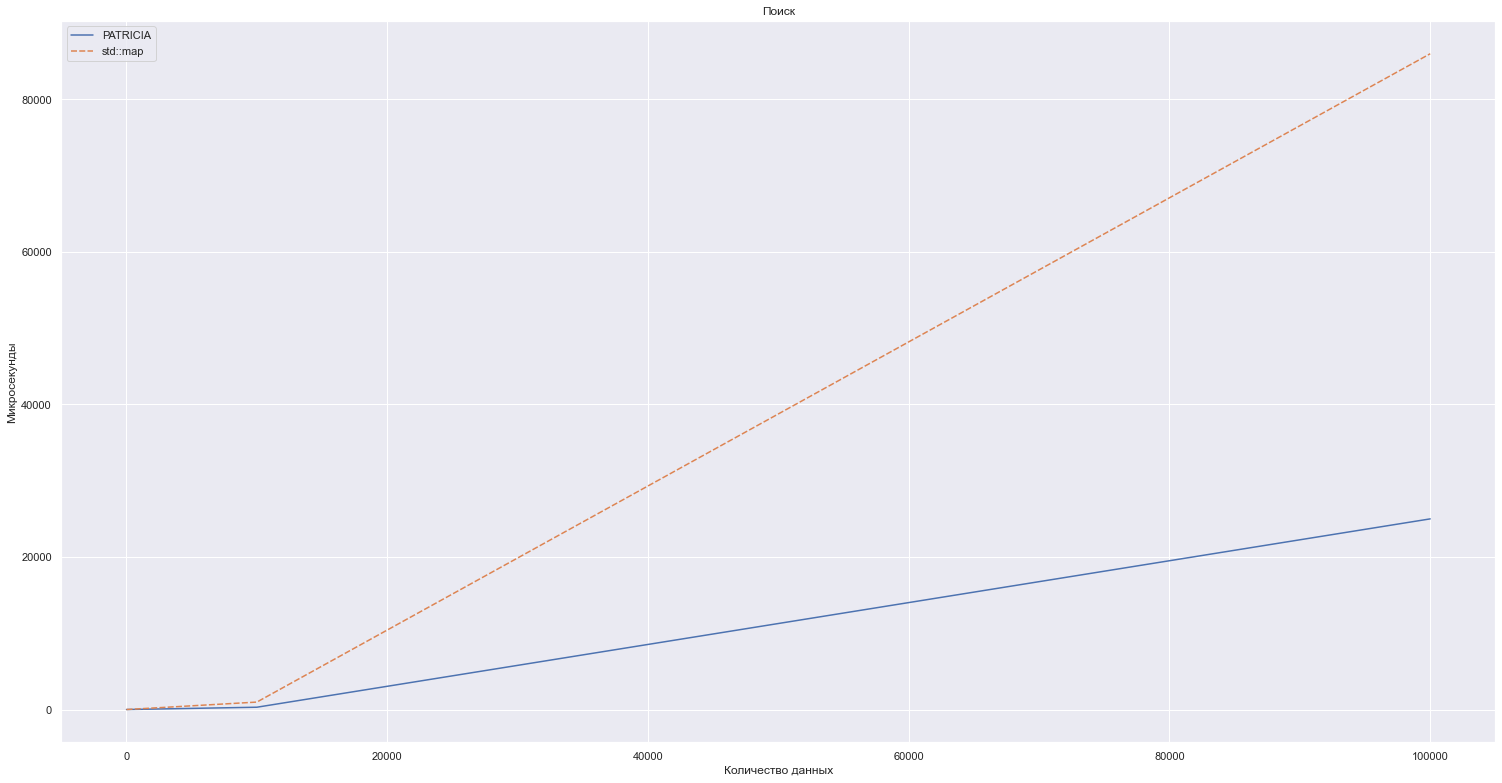

In [31]:
data = {"PATRICIA": [0, 0, 2, 25, 300, 25000], "std::map": [0, 1, 7, 94, 975, 86000]}


df = pd.DataFrame(data, index = [1, 10, 100, 1000, 10000, 100000])
sns.set(rc={'figure.figsize':(25.7,13.27)})

g = sns.lineplot(data=df)
#g.set(xscale = "log")
plt.xlabel("Количество данных")
plt.ylabel("Микросекунды")
plt.title("Поиск")